# Validate image-genominc-coding

* Refer to CMC: https://github.com/HobbitLong/CMC/blob/master/train_CMC.py

* Refer to InceptionV3: https://pytorch.org/hub/pytorch_vision_inception_v3/

* Refer to more pretrained nets: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [2]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

import skimage
import skimage.io
import tifffile

import time
import torch
import torch.hub
import torch.nn
# import torchvision.models  # does not work

# Self-defined functions
from alias_multinomial import AliasMethod

/project/DPDS/Xiao_lab/shared/qin_zhou/environments/envs/MicNet/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Load data

(25233, 27452, 3)


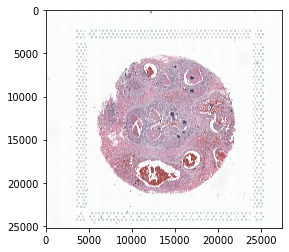

In [3]:
### Read counts
count_stat = pd.read_csv("./run/1_count_stat_breast_cancer_FFPE.csv", index_col=0)
count = pd.read_csv("./run/1_pd_count_norm_breast_cancer_FFPE.csv", index_col=0)
image_file = "./dataset/Visium_FFPE_Human_Breast_Cancer_image.tif"
image = tifffile.imread(os.path.join(image_file))
print(image.shape)
image_norm = image.copy()
plt.imshow(image_norm)
plt.show()

In [3]:
# Read position meta file
transformation_file =  "./dataset/Spot_metadata.csv"
pd_meta = pd.read_table(transformation_file, index_col=0, sep=",")
pd_meta

,Row,Col,X,Y,Spot_radius
0,,,,,
GTAGACAACCGATGAA-1,7,55,5406,13126,94
ACAGATTAGGTTAGTG-1,7,57,5407,13417,94
TGGTATCGGTCTGTAT-1,7,59,5407,13707,94
ATTATCTCGACAGATC-1,7,61,5407,13997,94
TGAGATCAAATACTCA-1,7,63,5407,14287,94
...,...,...,...,...,...
GCCCTGAGGATGGGCT-1,68,74,20805,15869,94
CGGGCGATGGATCACG-1,69,75,21057,16013,94
TGCGGACTTGACTCCG-1,68,76,20805,16159,94


In [5]:
# Split training and testing
np.random.seed(82321)
indexes_all = pd_meta.index.values.copy()
training_indexes = np.random.choice(indexes_all, int(len(indexes_all) * 0.8), replace=False)
testing_indexes = [_ for _ in indexes_all if _ not in training_indexes]
print("#Training: {}, #Testing: {}".format(len(training_indexes), len(testing_indexes)))
training_indexes.sort()
testing_indexes.sort()

#Training: 2014, #Testing: 504


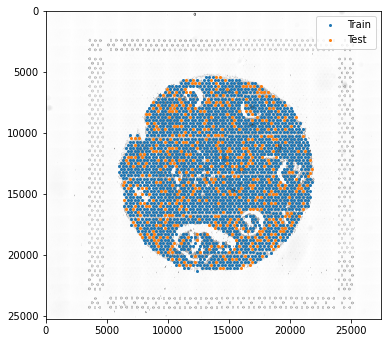

In [6]:
# Plot training & testing distribution
plt.figure(figsize=(6, 6))
plt.imshow(image_norm[..., 0], cmap="gray")
coords_x = pd_meta.loc[training_indexes, "Y"].values
coords_y = pd_meta.loc[training_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Train")
coords_x = pd_meta.loc[testing_indexes, "Y"].values
coords_y = pd_meta.loc[testing_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Test")
plt.gca().set_aspect('equal')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.legend()
plt.show()

In [9]:
PATCH_SIZE = 256

## 2) Check data loader

In [10]:
# from utils_data import Dataset
from utils_data import normalize, augmentor

import numpy as np
import math
import skimage
import skimage.transform

import torch
import torch.utils
import torch.utils.data
    
# Get image patch
def get_image_patch(image, coords, patch_size):
    """
    Args:
        coords: center of image; x, y (col, row) in pixels
    """
    row_start = int(coords[1] - patch_size/2)
    col_start = int(coords[0] - patch_size/2)
    return image[row_start:row_start + patch_size, col_start:col_start + patch_size]

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes, image, count_df, meta_df, augmentation=False):
        """
        Args:
            indexes: index used for both count_df and meta_df
        """
        self.indexes = indexes
        self.image = image
        self.count_df = count_df
        self.meta_df = meta_df
        self.augmentation = augmentation
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes)
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        Returns:
            index: indexes of samples (long)
        """
        # Generate data
        data = self.__data_generation(self.indexes[index])

        return data, index
    
    def __data_generation(self, indexes):
        """Generates data containing batch_size samples.
        
        Returns:
            data: a dictionary with data.image in [b, ch, h, w]; data.gene in [b, n_genes]
        """
        image = get_image_patch(self.image, 
                                [self.meta_df.loc[indexes, "Y"], self.meta_df.loc[indexes, "X"]], 
                                PATCH_SIZE)  # meta_df mistakes X/Y
        if self.augmentation:
            image = augmentor(normalize(image))
        else:
            image = normalize(image)
        
        data = dict()
        data['image'] = torch.tensor(np.transpose(image, (2, 0, 1)).astype(float))
        data['gene'] = torch.tensor(self.count_df.loc[indexes, :].values)
        
        return data 

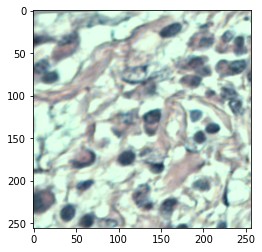

tensor([66])


In [11]:
# Generator
np.random.seed()
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)
for x, y in train_loader:
    plt.imshow(normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True))
    plt.show()
    print(y)
    break

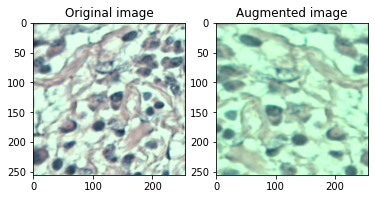

In [12]:
image = normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True)
plt.subplot(121)
plt.imshow(image)
plt.title("Original image")
plt.subplot(122)
plt.imshow(normalize(augmentor(normalize(image)), inverse=True))
plt.title("Augmented image")
plt.show()

## 3) Create network

In [13]:
class IGCNet(torch.nn.Module):
    def __init__(self, image_shape, n_genes, n_out_features, 
                 imagenet='resnet101', 
                 genenet=[500, 100]):
        """
        Args:
            image_shape: w/h of input image
            n_genes: number of genes to consider
            n_out_features: number of output features
            imagenet: architecture to encode image features
            genenet: architecture to encode genetic features: list of #hidden nodes
        """
        super(IGCNet, self).__init__()

        if imagenet == 'resnet101':
            # Require image size at least 224
            self.imagenet = torch.hub.load('pytorch/vision:v0.4.0', imagenet, pretrained=True)
            self.imagenet.float()
            self.imagenet.layer4[2].relu = torch.nn.ReLU6()
            self.imagenet.fc = torch.nn.Linear(self.imagenet.fc.in_features, n_out_features)
            input_size = image_shape
        elif imagenet == 'inception_v3':
            # Require image input size = 299, has auxillary output
            self.imagenet = torch.hub.load('pytorch/vision:v0.4.0', imagenet, pretrained=True)
            self.imagenet.float()
            raise("Incomplete model")
        else:
            raise("Invalid model name")

        genenet_fcs = []
        genenet_in_shape = n_genes
        for i, genenet_n_hidden_nodes in enumerate(genenet):
            genenet_fcs.append(torch.nn.Linear(genenet_in_shape, genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.BatchNorm1d(genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.ReLU6())
            genenet_in_shape = genenet_n_hidden_nodes
        genenet_fcs.append(torch.nn.Linear(genenet_in_shape, n_out_features))
        self.genenet_fcs = torch.nn.ModuleList(genenet_fcs)

    def forward(self, data):
        """
        Args:
            data: a dictionary
        """
        image, gene = data['image'], data['gene']
        f_image = self.imagenet(image)
        
        f_gene = gene
        for layer in self.genenet_fcs:
            f_gene = layer(f_gene)
        
        return f_image, f_gene

In [14]:
from torch.nn.modules import MSELoss
from utils_eval import NCESoftmaxLoss, NCECriterion
# from IGCmodel import IGCNet, NCEAverage
from IGCmodel import NCEAverage

device = torch.device("cuda:1")
image_shape = PATCH_SIZE
n_genes = count_stat.shape[1]
n_data = len(training_indexes)
n_out_features = 100
imagenet = 'resnet101'

# NCE parameters
# Increasing nce_m improves stability
# !!! Adding batch normalization layer improves stability 
nce_k = 100
nce_t = 0.07
nce_m = 0.9
softmax = False

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.01   # ori 0.01
momentum = 0.9
weight_decay = 0.0001
gradient_clip = 5

# Generator
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=1)
test_set = Dataset(testing_indexes, image_norm, count, pd_meta, augmentation=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False, num_workers=1)

# Set model
model = IGCNet(image_shape=image_shape, n_genes=n_genes, n_out_features=n_out_features, 
               imagenet=imagenet, genenet=[500, 100]).to(device)
contrast = NCEAverage(n_out_features, n_data, nce_k, nce_t, nce_m, softmax, device=device).to(device)
criterion_image = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)
criterion_gene = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)
criterion_rec = MSELoss().to(device)

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

Using cache found in /home2/s223242/.cache/torch/hub/pytorch_vision_v0.4.0


In [15]:
model_dir = "./models/2_IGC_breast_cancer_FFPE"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [16]:
model

IGCNet(
  (imagenet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [ ]:
"""TO LOAD:"""

model_file = os.path.join(model_dir, "epoch_best_breast.pt")
if model_file is not None:
    print("=> loading checkpoint '{}'".format(model_file))
    checkpoint = torch.load(model_file, map_location=device)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    contrast.load_state_dict(checkpoint['contrast'])
    del checkpoint

## 4) Validate and save result

In [19]:
test_set = Dataset(indexes_all, image_norm, count, pd_meta, augmentation=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False, num_workers=1)

In [20]:
model.eval()

with torch.no_grad():
    for idx, (data, index) in enumerate(test_loader):
        batch_size = data['image'].size(0)
        index = index.to(device)
        for _ in data.keys():
            data[_] = data[_].float().to(device)

        # ===================forward=====================
        feat_image, feat_gene = model(data)
        
        # Append
        if idx == 0:
            feat_images = feat_image.cpu().numpy()
            feat_genes = feat_gene.cpu().numpy()
        else:
            feat_images = np.concatenate([feat_images, feat_image.cpu().numpy()])
            feat_genes = np.concatenate([feat_genes, feat_gene.cpu().numpy()])

In [21]:
feat_images.shape

(2518, 100)

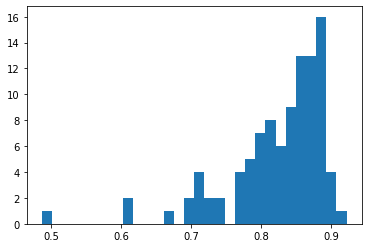

In [22]:
# Normalize & calculate correlation
from scipy.stats import spearmanr

feat_images = feat_images / np.sum(feat_images ** 2, axis=1, keepdims=True) ** 0.5
feat_genes = feat_genes / np.sum(feat_genes ** 2, axis=1, keepdims=True) ** 0.5
corr = []
for i in range(feat_images.shape[1]):
    corr.append(spearmanr(feat_images[:, i], feat_genes[:, i]).correlation)
plt.hist(corr, bins=30)
plt.show()

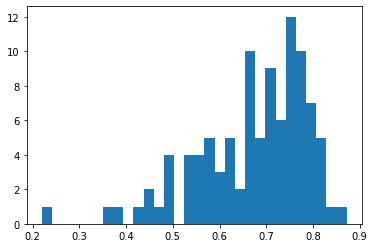

In [23]:
# Normalize & calculate correlation in testing set
from scipy.stats import spearmanr

_feat_images = np.array([feat_images[_, :] for _, index in enumerate(indexes_all) if index in testing_indexes])
_feat_genes = np.array([feat_genes[_, :] for _, index in enumerate(indexes_all) if index in testing_indexes])
corr = []
for i in range(_feat_images.shape[1]):
    corr.append(spearmanr(_feat_images[:, i], _feat_genes[:, i]).correlation)
plt.hist(corr, bins=30)
plt.show()

In [24]:
# Save result
torch.save([feat_images, feat_genes], "./output/3_IGC_breast_cancer_FFPE_all_indexes_features.pt")